# Beating the brazilian future market with ML and Statistics:

# 1: Pre-processing:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Reading data as data frame:
df30min = pd.read_csv('data/petr4-30min-03-03.csv')

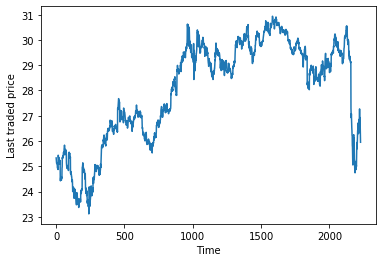

In [72]:
# Plotting close prices:
#df30min.Ultima.plot()
sns.lineplot(data=df30min.Ultima)
plt.xlabel('Time')
plt.ylabel('Last traded price')
plt.show()

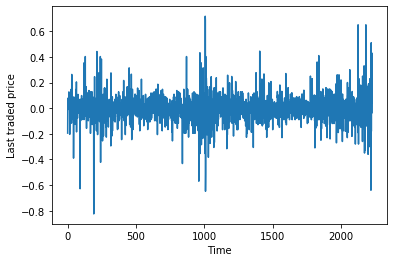

In [73]:
sns.lineplot(data=(df30min.Abertura - df30min.Ultima))
plt.xlabel('Time')
plt.ylabel('Last traded price')
plt.show()

## 1.1: Finding data type and features without auto-collinearity:

    - Our series (features) should contain independent observations. If not,
    this will have consequences when building regressive models which will
    mislead our interpretations and predictions;

    - It is preferable tick-bar, volume-bar or imbalance-bar, which have
    lower collinearity than time based bars.

    - Gaps between trade sessions, in time based bars, have a negative
    impact in ML prediction accuracy.

In [4]:
# Checking auto-correlations:
for i in df30min.columns[2:]:
    print('{}:      '.format(i), df30min[i].autocorr())

Abertura:       0.997815966358893
Maxima:       0.9980188132721973
Minima:       0.997694641259572
Ultima:       0.9978534031745122
Negocios:       0.565497559523146
Volume:       0.32867001591479944
Amplitude:       0.5072775743684663
Return:       0.0016825990317024771


**Volume, Negocios** are the best features for fitting our ML
models because they have the least auto-collinearity among the others.

## 1.2: Finding and checking multi-collinearity:

    - We can create pairwised features between 2 features with high
    collinearity.

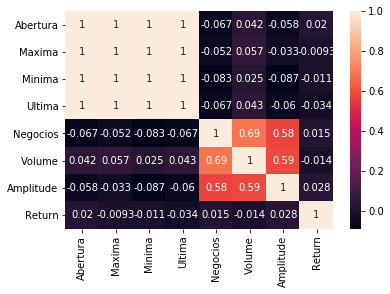

In [5]:
# Checking correlations between features:
sns.heatmap(data=df30min.corr(), annot=True)
plt.show()

Since, **Abertura, Maxima, Minima, Ultima** have the highest
multi-collinearity, then we will create pairwised features from them:

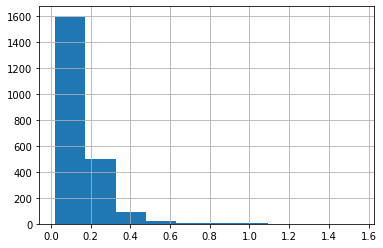

Amplitude:  0.5072775743684663


In [14]:
# Creating feature with the difference between max and min:
df30min['Amplitude'] = df30min.Maxima - df30min.Minima

# Printing distribution:
df30min.Amplitude.hist()
plt.show()

print('Amplitude: ', df30min['Amplitude'].autocorr())

- Still high auto-collinearity and not normally distributed.

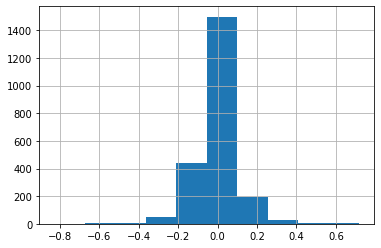

Return:  0.0016825990317024771


In [3]:
# Creating feature with the return of the period:
df30min['Return'] = df30min.Abertura - df30min.Ultima

# Printing distribution:
df30min.Return.hist()
plt.show()

print('Return: ', df30min['Return'].autocorr())

- **Very low auto-collinearity and also normally distributed.**

- This is exactly what we are looking for!

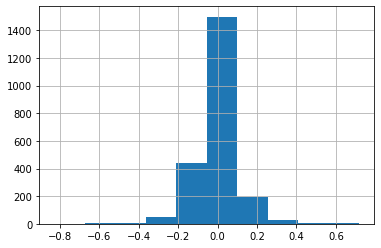

Return:  -0.004905554605180236


In [6]:
# Creating feature with the return of the period:
df30min['Return'] = df30min.Abertura - df30min.Ultima

# Printing distribution:
df30min.Return.hist()
plt.show()

print('Return: ', df30min['Return'].autocorr())

In [66]:
# Creating class labels:


# 2) Importing historical data from IB:

In [33]:
from ibapi.client import EClient
from ibapi.wrapper import EWrapper
from ibapi.contract import Contract
import time
import pandas as pd

class IBapi(EWrapper, EClient):
    def __init__(self):
        EWrapper.__init__(self)
        EClient.__init__(self, self)

app = IBapi()
app.connect('127.0.0.1', 7496, 123)
print("serverVersion:%s connectionTime:%s" %
      (app.serverVersion(),app.twsConnectionTime()))

time.sleep(5)

serverVersion:155 connectionTime:b'20200519 19:07:14 CET'


In [36]:
# Create contract object
con = Contract()
con.symbol = 'PETR4'
con.secType = 'STK'
con.exchange = 'BOVESPA'
con.currency = 'BRL'

app.reqContractDetails(2, con)

ERROR -1 504 Not connected


In [40]:
#Create empty variable to store candles
app.data = []

#Request historical candles
app.reqHistoricalData(
    1,  # tickerId
    con,  # contract
    None,  # endDateTime
    '1 M',  # durationString
    '1 day',  # barSizeSetting
    'TRADES',  # whatToShow
    0,  # useRTH=1 to retrieve data generated only within (RTH)
    None,  # formatDate='yyyyMMdd'
    False,  #keepUpToDate
    []  # chartOptions
)

time.sleep(5)

df = pd.DataFrame(app.data)

app.disconnect()

ERROR 1 504 Not connected
